# Import Libraries #

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import cv2
import pickle
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from sklearn.metrics import roc_curve, auc 
from tensorflow_model_optimization.sparsity import keras as sparsity

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.layers.normalization import BatchNormalization

from datetime import datetime

%load_ext tensorboard
import tensorboard
import tempfile
import zipfile
import os


In [16]:
adam_opt = tf.keras.optimizers.Adam(learning_rate= 1e-3)
bce = tf.keras.losses.BinaryCrossentropy()

def check_binarized_auc(test_dset, model, X_test, y_test):
    '''Input:
            test_dset: test dataset to analyze performance of model on unseen data
            model: keras model trained previously
            
       Output:
            None: print out test AUC in function
    '''  
    y_pred = model.predict(X_test).ravel()
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    auc_model = auc(fpr, tpr)
    output = 'Test AUC: {}'
    print(output.format(auc_model))
    
    #sens and spec at Youden's index
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    sens = tpr[optimal_idx]
    spec = 1 - fpr[optimal_idx]
    print('Sensitivity: ' + str(sens))
    print('Specificity: ' + str(spec))
    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model (area = {:.3f})'.format(auc_model))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
def loss_plot(hist, epoch=50):
    plt.figure()
    plt.plot(range(epoch), hist.history['loss'], label='Training loss')
    plt.plot(range(epoch), hist.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    # END CODE #
    plt.show()

#functions to get nonzero weights 
def total_nonzero_weights(model):
    '''return total number of nonzero weights (total params)
    includes non-trainable params'''
    weights = model.get_weights()
    count_nz = []
    for i in range(len(weights)):
        count_nz.append(np.count_nonzero(weights[i]))
    return sum(count_nz)

def total_nonzero_trainable_weights(model):
    '''return total number of nonzero trainable weights'''
    w = []
    for v in model.trainable_variables:
        w.append(tf.math.count_nonzero(v))
    return sum(w)    

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TF Version: ", tf.version.VERSION)

Num GPUs Available:  1
TF Version:  1.15.0


# Dictionary of images and labels #

In [4]:
IMAGE_PATH =  '/home/djun36/project/ham10000_images/' 
LABEL_PATH = '/home/djun36/project/HAM10000_metadata.csv' 

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses', #Because it can become cancerous, it's usually removed as a precaution.
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Dictionary for binary Malignant and Benign labels. May want to change the terminology because of akiec 
lesion_referral_dict = {
    'nv': 'Benign',
    'mel': 'Malignant',
    'bkl': 'Benign',
    'bcc': 'Malignant',
    'akiec': 'Malignant',
    'vasc': 'Benign',
    'df': 'Benign'
}

# Process data #

In [5]:
skin_df = pd.read_csv(LABEL_PATH)

# Creating New Columns for better readability

#skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df['referral'] = skin_df['dx'].map(lesion_referral_dict.get)

In [6]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,referral
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,Benign
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,Benign
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,Benign
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,Benign
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,Benign


# Data Cleaning #

In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type         0
cell_type_idx     0
referral          0
dtype: int64

In [8]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [9]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type        0
cell_type_idx    0
referral         0
dtype: int64

In [10]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
cell_type         object
cell_type_idx       int8
referral          object
dtype: object


# Data Viz #

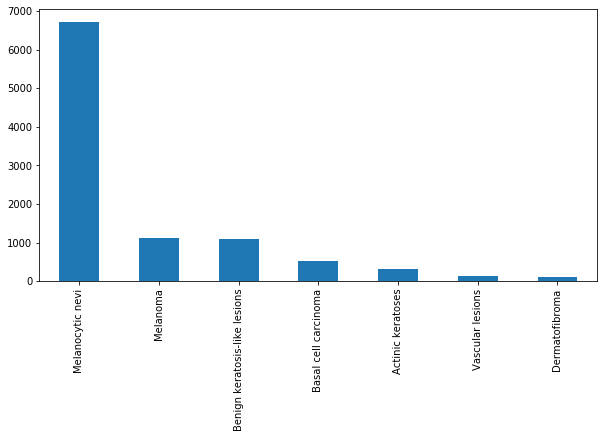

In [11]:
# Plot to see distribution of 7 different classes of cell type
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

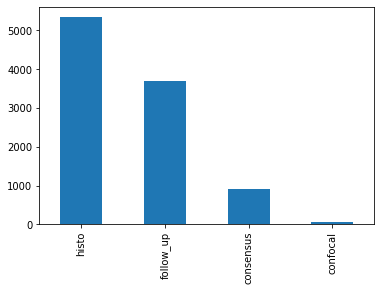

In [12]:
skin_df['dx_type'].value_counts().plot(kind='bar')

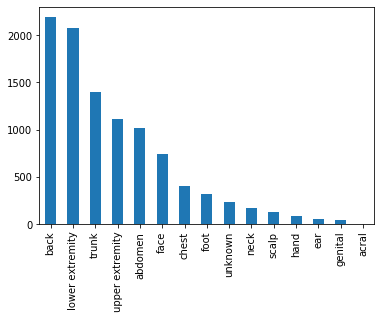

In [13]:
skin_df['localization'].value_counts().plot(kind='bar')

Benign       8061
Malignant    1954
Name: referral, dtype: int64
Benign % 0.8048926610084872 
Malignant % 0.19510733899151272


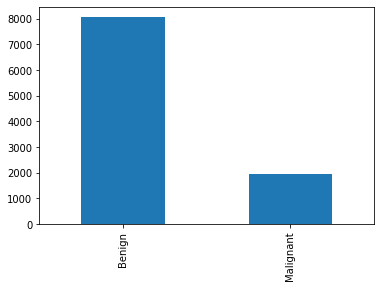

In [14]:
skin_df['referral'].value_counts().plot(kind='bar')

print(skin_df['referral'].value_counts())
print('Benign %', 8061/10015, '\nMalignant %', 1954/10015)

# Balancing Dataset #
Randomly sample 1954 images from each class

In [17]:
no_ref = skin_df.loc[skin_df['referral'] == 'Benign']['image_id'].values.tolist()
ref = skin_df.loc[skin_df['referral'] == 'Malignant']['image_id'].values.tolist()

random.seed(1)
no_refer_examples = random.sample(no_ref, 1954)
refer_examples = random.sample(ref, 1954)

all_files = no_refer_examples + refer_examples
random.shuffle(all_files)

# Resizing Images and Splitting Data #
Split data into train, tune, test with 0.6, 0.2, 0.2 split

In [9]:
IMAGE_SIZE = (224, 224)

def load_data(all_files, IMAGE_SIZE):
    '''Input:
            all_files: list of image names to load in
            
       Output:
            X_train, X_tune, X_test: preprocessed images split in 0.6, 0.2, 0.2 respectively
            y_train, y_tune, y_test: binary labels split in 0.6, 0.2, 0.2 respectively
    '''  
    
    train_images = []
    train_labels = []
    
    #random.seed(1)
    #random.shuffle(all_files)
    labels_df = pd.read_csv(LABEL_PATH)

    for file in all_files:
        
        # FILL IN CODE HERE #
        
        img = load_img(IMAGE_PATH + file + '.jpg')
        array = img_to_array(img)
        resize = cv2.resize(array, IMAGE_SIZE, interpolation = cv2.INTER_LANCZOS4)
        norm_img = cv2.normalize(resize, None, 0, 1, norm_type=cv2.NORM_MINMAX)  #normalize image to 0 to 1
        
        if file in no_refer_examples:
            img_label = 0
        else:
            img_label = 1
         
        train_images.append(norm_img)
        train_labels.append(img_label)
        
        # END CODE #

    all_images = np.stack(train_images)
    all_labels = np.array(train_labels).flatten()
    
    total_data = len(all_images)
    num_train = round(total_data * 0.6)
    num_tune = round(total_data * 0.2)
    num_test = round(total_data * 0.2)
    
    # FILL IN CODE HERE #
    
    X_train = all_images[0:num_train]
    y_train = all_labels[0:num_train]
    X_tune = all_images[num_train: (num_train + num_tune)]
    y_tune = all_labels[num_train: (num_train + num_tune)]
    X_test = all_images[(num_train + num_tune):]
    y_test = all_labels[(num_train + num_tune):]
    
    # END CODE #

    return X_train, y_train, X_tune, y_tune, X_test, y_test

X_train, y_train, X_tune, y_tune, X_test, y_test = load_data(all_files, IMAGE_SIZE)

In [10]:
#for iv3 data with size (299, 299)
iX_train, iy_train, iX_tune, iy_tune, iX_test, iy_test = load_data(all_files, (299, 299))

In [4]:
#pickle.dump([X_train, y_train, X_tune, y_tune, X_test, y_test], open('ham10000_3.9k', 'wb'))
#pickle.dump([iX_train, iy_train, iX_tune, iy_tune, iX_test, iy_test], open('ham10000_3.9k_i', 'wb'))

X_train, y_train, X_tune, y_tune, X_test, y_test = pickle.load(open('ham10000_3.9k', 'rb'))
iX_train, iy_train, iX_tune, iy_tune, iX_test, iy_test = pickle.load(open('ham10000_3.9k_i', 'rb'))

In [5]:
BATCH_SIZE = 16

train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
tune_dset = tf.data.Dataset.from_tensor_slices((X_tune, y_tune)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

itrain_dset = tf.data.Dataset.from_tensor_slices((iX_train, iy_train)).batch(BATCH_SIZE)
itune_dset = tf.data.Dataset.from_tensor_slices((iX_tune, iy_tune)).batch(BATCH_SIZE)
itest_dset = tf.data.Dataset.from_tensor_slices((iX_test, iy_test)).batch(BATCH_SIZE)

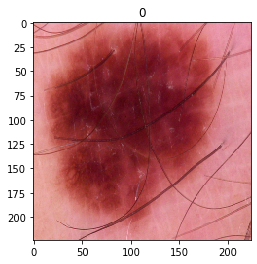

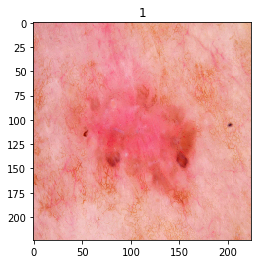

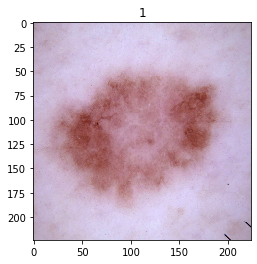

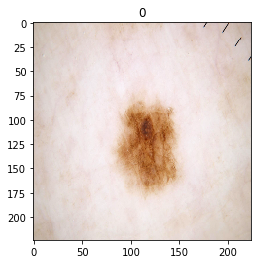

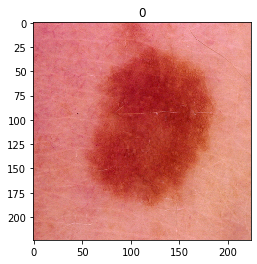

In [5]:
for i in range(5):
    plt.imshow(X_train[i]) # Shows the image on a plot
    plt.title(y_train[i]) # Titles the image with the label
    plt.show()

# Create MN2 baseline model
We will be using a MobileNet (https://arxiv.org/abs/1704.04861) pre-trained on ImageNet as our base model and fine-tuning it on our dataset.

In [6]:
mn2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mn2.layers))

# Fine-tune from this layer onwards
mn2.trainable = True
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in mn2.layers[:fine_tune_at]:
  layer.trainable =  False

mn2.summary()

Number of layers in the base model:  157
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________

In [8]:
# Build the model
h1 = tf.keras.layers.GlobalAveragePooling2D()(mn2.layers[-3].output) 
prediction = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(h1)
mn2_b = tf.keras.Model(inputs=mn2.input, outputs=prediction)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 1e-3)
bce = tf.keras.losses.BinaryCrossentropy()

mn2_b.compile(optimizer= adam_opt,
              loss= bce,
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
mn2_b_hist = mn2_b.fit(train_dset, 
                 epochs=50,  
                 validation_data = tune_dset)

Train on 147 steps, validate on 49 steps
Epoch 1/5
147/147 [==============================] - 47s 320ms/step - loss: 0.5483 - acc: 0.7399 - val_loss: 1.6129 - val_acc: 0.5090
Epoch 2/5
147/147 [==============================] - 33s 224ms/step - loss: 0.4650 - acc: 0.7783 - val_loss: 5.0618 - val_acc: 0.5051
Epoch 3/5
147/147 [==============================] - 33s 224ms/step - loss: 0.4385 - acc: 0.7898 - val_loss: 2.5866 - val_acc: 0.4974
Epoch 4/5
147/147 [==============================] - 33s 224ms/step - loss: 0.3612 - acc: 0.8303 - val_loss: 5.4364 - val_acc: 0.4949
Epoch 5/5
147/147 [==============================] - 32s 220ms/step - loss: 0.3609 - acc: 0.8286 - val_loss: 1.4762 - val_acc: 0.4923


In [10]:
#save model
mn2_b.save('mn2_b.h5')

#mn2_b = tf.keras.models.load_model('mn2_b.h5')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 21:58:42


# Evaluate Model

In [11]:
mn2_b.evaluate(test_dset)

49/49 [==============================] - 4s 79ms/step - loss: 1.4042 - acc: 0.5096


[1.4041828561802299, 0.5096031]

Output with sigmoid, default lr, mn2_b: [1.1074739817757995, 0.8002561]

Test AUC: 0.6863323887489505
Sensitivity: 0.5104166666666666
Specificity: 0.7959697732997482


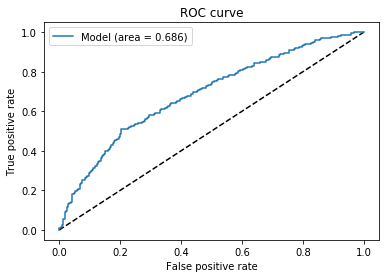

ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

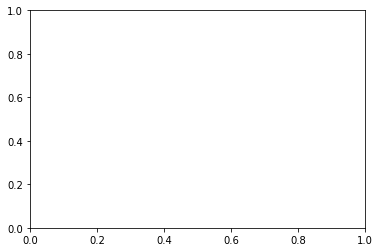

In [12]:
check_binarized_auc(test_dset, mn2_b, X_test, y_test)
loss_plot(mn2_b_hist)

# Create Inception V3 baseline model

In [19]:
iv3 = tf.keras.applications.InceptionV3(weights='imagenet')
#mobileNet = tf.keras.applications.MobileNet()
iv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
iv3.trainable = True
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in iv3.layers[:fine_tune_at]:
  layer.trainable =  False

iv3.summary()
print("Number of layers in the base model: ", len(iv3.layers))
#print("trainable layers: ", len(iv3.trainable_variables))

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
# Build the model
d1 = tf.keras.layers.Dropout(0.5)(iv3.layers[-3].output) 
h1 = tf.keras.layers.GlobalAveragePooling2D()(d1) #(iv3.layers[-3].output) 
prediction = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(h1)
iv3_b = tf.keras.Model(inputs=iv3.input, outputs=prediction)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 1e-3)
bce = tf.keras.losses.BinaryCrossentropy()

iv3_b.compile(optimizer= adam_opt,
              loss= bce,
              metrics=['accuracy'])

In [30]:
iv3_b_hist = iv3_b.fit(itrain_dset, 
                 epochs=50, 
                 #callbacks = [lr_scheduler], 
                 validation_data = itune_dset)

Epoch 1/50
147/147 [==============================] - 28s 190ms/step - loss: 6.1408e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/50
147/147 [==============================] - 28s 189ms/step - loss: 5.4225e-07 - acc: 1.0000 - val_loss: 1.6290 - val_acc: 0.8043
Epoch 3/50
147/147 [==============================] - 28s 190ms/step - loss: 5.0920e-07 - acc: 1.0000 - val_loss: 1.6419 - val_acc: 0.8031
Epoch 4/50
147/147 [==============================] - 28s 191ms/step - loss: 4.4741e-07 - acc: 1.0000 - val_loss: 1.6550 - val_acc: 0.8056
Epoch 5/50
147/147 [==============================] - 28s 190ms/step - loss: 4.3292e-07 - acc: 1.0000 - val_loss: 1.6581 - val_acc: 0.8031
Epoch 6/50
147/147 [==============================] - 28s 190ms/step - loss: 3.9143e-07 - acc: 1.0000 - val_loss: 1.6638 - val_acc: 0.8056
Epoch 7/50
147/147 [==============================] - 28s 190ms/step - loss: 3.5322e-07 - acc: 1.0000 - val_loss: 1.6767 - val_acc: 0.8043
Epoch 8/50
147/147 

In [5]:
#save model
#iv3_b.save('iv3_b.h5')

iv3_b = tf.keras.models.load_model('iv3_b.h5')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

OSError: SavedModel file does not exist at: iv3_b.h5/{saved_model.pbtxt|saved_model.pb}

# Evaluate Model

In [31]:
iv3_b.evaluate(itest_dset)

49/49 [==============================] - 3s 52ms/step - loss: 2.5018 - acc: 0.7734


[2.5017785106319934, 0.77336746]

Output with sigmoid, default lr, iv3_b: [1.69085515989941, 0.7810499]

Test AUC: 0.8475020990764063
Sensitivity: 0.9192708333333334
Specificity: 0.6624685138539043


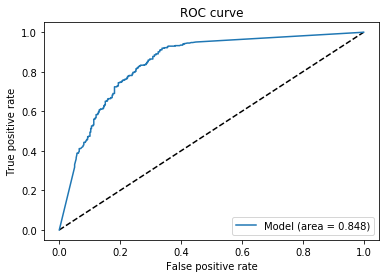

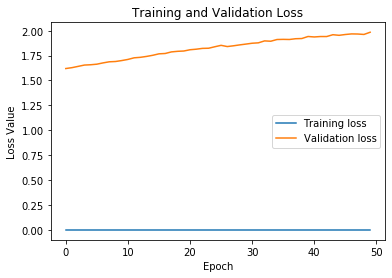

In [32]:
check_binarized_auc(itest_dset, iv3_b, iX_test, iy_test)
loss_plot(iv3_b_hist)

# Create ResNet50v2 baseline model

In [ ]:
rn50 = tf.keras.applications.ResNet50V2(weights='imagenet')
rn50.summary()

In [ ]:
# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
rn50.trainable = True
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in rn50.layers[:fine_tune_at]:
  layer.trainable =  False

rn50.summary()
print("Number of layers in the base model: ", len(rn50.layers))
print("trainable layers: ", len(rn50.trainable_variables))

In [ ]:
# Build the model
h1 = tf.keras.layers.GlobalAveragePooling2D()(rn50.layers[-3].output) 
prediction = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(h1)
rn50_b = tf.keras.Model(inputs=rn50.input, outputs=prediction)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 1e-3)
bce = tf.keras.losses.BinaryCrossentropy()

rn50_b.summary()
print("Number of layers in the base model: ", len(rn50_b.layers))
print("trainable layers: ", len(rn50_b.trainable_variables))

'''rn50_b.compile(optimizer= adam_opt,
              loss= bce,
              metrics=['accuracy'])'''

In [ ]:
rn50_b_hist = rn50_b.fit(train_dset, 
                 epochs=75, 
                 #callbacks = [lr_scheduler], 
                 validation_data = tune_dset)

In [ ]:
#save model
rn50_b.save('rn50_b.h5')

#iv3_b = tf.keras.models.load_model('iv3_b.h5')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

# Evaluate Model

In [ ]:
rn50_b.summary()

In [ ]:
rn50_b.evaluate(test_dset)

In [ ]:
check_binarized_auc(test_dset, rn50_b, X_test, y_test)
loss_plot(rn50_b_hist, 75)

# Create ResNet152v2 baseline model

In [43]:
rn152 = tf.keras.applications.ResNet152V2(weights='imagenet')
#mobileNet = tf.keras.applications.MobileNet()
rn152.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [45]:
#rn50
rn152 = tf.keras.applications.ResNet50V2(weights='imagenet')
rn152.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [46]:
# Let's take a look to see how many layers are in the base model

# Fine-tune from this layer onwards
rn152.trainable = True
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in rn152.layers[:fine_tune_at]:
  layer.trainable =  False

rn152.summary()
print("Number of layers in the base model: ", len(rn152.layers))
#print("trainable layers: ", len(iv3.trainable_variables))

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [47]:
# Build the model
h1 = tf.keras.layers.GlobalAveragePooling2D()(rn152.layers[-3].output) 
prediction = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(h1)
rn152_b = tf.keras.Model(inputs=rn152.input, outputs=prediction)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 1e-2)
bce = tf.keras.losses.BinaryCrossentropy()

rn152_b.compile(optimizer= adam_opt,
              loss= bce,
              metrics=['accuracy'])

In [48]:
rn152_b_hist = rn152_b.fit(train_dset, 
                 epochs=50, 
                 #callbacks = [lr_scheduler], 
                 validation_data = tune_dset)

Epoch 1/50
147/147 [==============================] - 26s 175ms/step - loss: 0.9558 - acc: 0.5198 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/50
147/147 [==============================] - 17s 115ms/step - loss: 0.7253 - acc: 0.5842 - val_loss: 9.5107 - val_acc: 0.3299
Epoch 3/50
147/147 [==============================] - 17s 115ms/step - loss: 0.6771 - acc: 0.6102 - val_loss: 1.4393 - val_acc: 0.7072
Epoch 4/50
147/147 [==============================] - 17s 115ms/step - loss: 0.6477 - acc: 0.6648 - val_loss: 10.5603 - val_acc: 0.6816
Epoch 5/50
147/147 [==============================] - 17s 115ms/step - loss: 0.6341 - acc: 0.6665 - val_loss: 0.8967 - val_acc: 0.7072
Epoch 6/50
147/147 [==============================] - 17s 115ms/step - loss: 0.5944 - acc: 0.6896 - val_loss: 0.5248 - val_acc: 0.7404
Epoch 7/50
147/147 [==============================] - 17s 115ms/step - loss: 0.5840 - acc: 0.6913 - val_loss: 0.5563 - val_acc: 0.7455
Epoch 8/50
147/147 [==========================

In [5]:
#save model
#rn152_b.save('rn50_b_l4.h5')

rn152_b = tf.keras.models.load_model('rn152_b.h5')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Current Time = 15:46:09


In [7]:
rn152_b.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
print("model:", total_nonzero_weights(rn152_b))

# Evaluate Model

In [6]:
rn152_b.evaluate(test_dset)

49/49 [==============================] - 13s 268ms/step - loss: 2.0673 - acc: 0.7337


[2.0673098316302103, 0.73367476]

Output with sigmoid, default lr, rn152_b: [2.0673098316302103, 0.73367476]

Test AUC: 0.8011453085642317
Sensitivity: 0.8151041666666666
Specificity: 0.6750629722921915


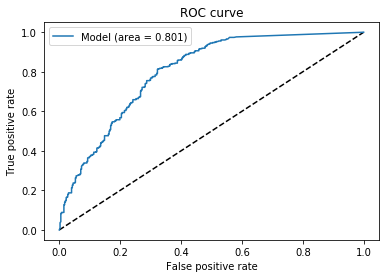

NameError: name 'rn152_b_hist' is not defined

In [7]:
check_binarized_auc(test_dset, rn152_b, X_test, y_test)
loss_plot(rn152_b_hist, 50)